In [1]:
# prepare image, mask from 206 segmentations data
import os
import gc
import random
import cv2
import time
import math
import pandas as pd
import nibabel as nib
import pydicom
import numpy as np

from glob import glob
from tqdm import tqdm
from pathlib import Path
# from monai.transforms import Resize

from sklearn.model_selection import GroupKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD, AdamW
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler

In [2]:
class CFG:
    seed = 42
    device = torch.device('cuda')
    n_fold = 5
    out_dim = 5
    accum_iter = 1
    max_grad_norm = 1000
    normalize_mean=[0.4824, 0.4824, 0.4824] 
    normalize_std=[0.22, 0.22, 0.22]
    epochs = 15
    img_size = 320
    backbone = "efficientnet-b0"
    optimizer = "AdamW"
    scheduler = "CosineAnnealingLR"
    loss_fn = 'BCEWithLogitsLoss'
    scheduler_warmup = 'GradualWarmupSchedulerV3'
    warmup_epo=1
    warmup_factor = 10
    T_max= epochs-warmup_epo-2 if scheduler_warmup=="GradualWarmupSchedulerV2" else \
           epochs-warmup_epo-1 if scheduler_warmup=="GradualWarmupSchedulerV3" else epochs-1
   
    lr=5e-3 
    min_lr=1e-6 #
    weight_decay=0 
    n_early_stopping=5
    batch_size = 16
    num_workers = 4
    print_freq = 100

In [134]:
Path(f"data/stage2").mkdir(parents=True, exist_ok=True)
Path(f"data/stage2/image").mkdir(parents=True, exist_ok=True)
Path(f"data/stage2/mask").mkdir(parents=True, exist_ok=True)
seg_path = 'data/segmentations/'
src_data = 'data/train_images/'
df = pd.read_parquet("data/train_dicom_tags.parquet")
df['StudyInstanceUID'] = df['SeriesInstanceUID'].apply(lambda x: x.split('.')[-1])

In [137]:
dataframe_list = []

def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = pydicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

In [138]:
for idx, filename in tqdm(enumerate(os.listdir(seg_path))):
    try:
        ex_path = os.path.join(seg_path, filename)
        mask_org = nib.load(ex_path)
        mask_org = mask_org.get_fdata()
        mask = mask_org[:, ::-1, ::-1].transpose(1, 0, 2)
        mask = np.clip(mask, 0, 8).astype(np.uint8)
        mask = np.ascontiguousarray(mask)
    
        study_id = filename.split('.')[0]
        row = df[df['StudyInstanceUID'] == study_id]
        patient_id = row['PatientID'].unique().tolist()
    
        assert len(patient_id) == 1, "the study should be of a patient"
        patient_id = str(patient_id[0])
        # train_image_path = glob(f'data/theoviel/{patient_id}_{study_id}_*')
        train_image_path = glob(f"{src_data}/{patient_id}/{study_id}/*")
        train_image_path = sorted(train_image_path, key=lambda x:int(x.split("/")[-1].replace(".dcm", "")))
        image_list = []
        for path in train_image_path:
            im, meta = load_dicom(path)
            image_list.append(im[:, :, 0])
        image = np.stack(image_list, axis=2)
        assert image.shape == mask.shape, 'image shape vs mask shape'
        slice_num = image.shape[2]
        for i in range(1, slice_num - 1):
            image_25d = image[:, :, i-1: i + 2]
            mask_25d = mask[:, :, i-1: i + 2]
            # assert image_25d.shape == mask_25d.shape == (512, 512, 3), "image shape vs mask shape same size 512 512 3"
            image_save_path = f"data/stage2/image/{patient_id}_{study_id}_{i}.npy"
            mask_save_path = f"data/stage2/mask/{patient_id}_{study_id}_{i}.npy"
            np.save(image_save_path, image_25d)
            np.save(mask_save_path, mask_25d)
            dataframe_list.append([study_id, image_save_path, mask_save_path])
    except:
        print('error in', filename)
        continue
    
# seg_25d_df = pd.DataFrame(dataframe_list, columns=["StudyInstanceUID", "image_path", "mask_path"])
# seg_25d_df['fold'] = -1
# gkf = GroupKFold(n_splits=5)
# for idx, (train_idx, test_idx) in enumerate(gkf.split(X=seg_25d_df, groups=seg_25d_df['StudyInstanceUID'].values)):
#     seg_25d_df.loc[test_idx, 'fold'] = idx
# seg_25d_df.to_csv('data/stage2/seg_25d.csv', index=False)

206it [3:13:24, 56.33s/it] 


In [139]:
seg_25d_df = pd.DataFrame(dataframe_list, columns=["StudyInstanceUID", "image_path", "mask_path"])
seg_25d_df['fold'] = -1
gkf = GroupKFold(n_splits=5)
for idx, (train_idx, test_idx) in enumerate(gkf.split(X=seg_25d_df, groups=seg_25d_df['StudyInstanceUID'].values)):
    seg_25d_df.loc[test_idx, 'fold'] = idx
seg_25d_df.to_csv('data/stage2/seg_25d.csv', index=False)

In [140]:
train_df = pd.read_csv('data/stage2/seg_25d.csv')
print('train_df shape', train_df.shape)
train_df.head()

train_df shape (70129, 4)


,StudyInstanceUID,image_path,mask_path,fold
0,6575,data/stage2/image/20951_6575_1.npy,data/stage2/mask/20951_6575_1.npy,3
1,6575,data/stage2/image/20951_6575_2.npy,data/stage2/mask/20951_6575_2.npy,3
2,6575,data/stage2/image/20951_6575_3.npy,data/stage2/mask/20951_6575_3.npy,3
3,6575,data/stage2/image/20951_6575_4.npy,data/stage2/mask/20951_6575_4.npy,3
4,6575,data/stage2/image/20951_6575_5.npy,data/stage2/mask/20951_6575_5.npy,3


(3, 512, 512)
(3, 512, 512)


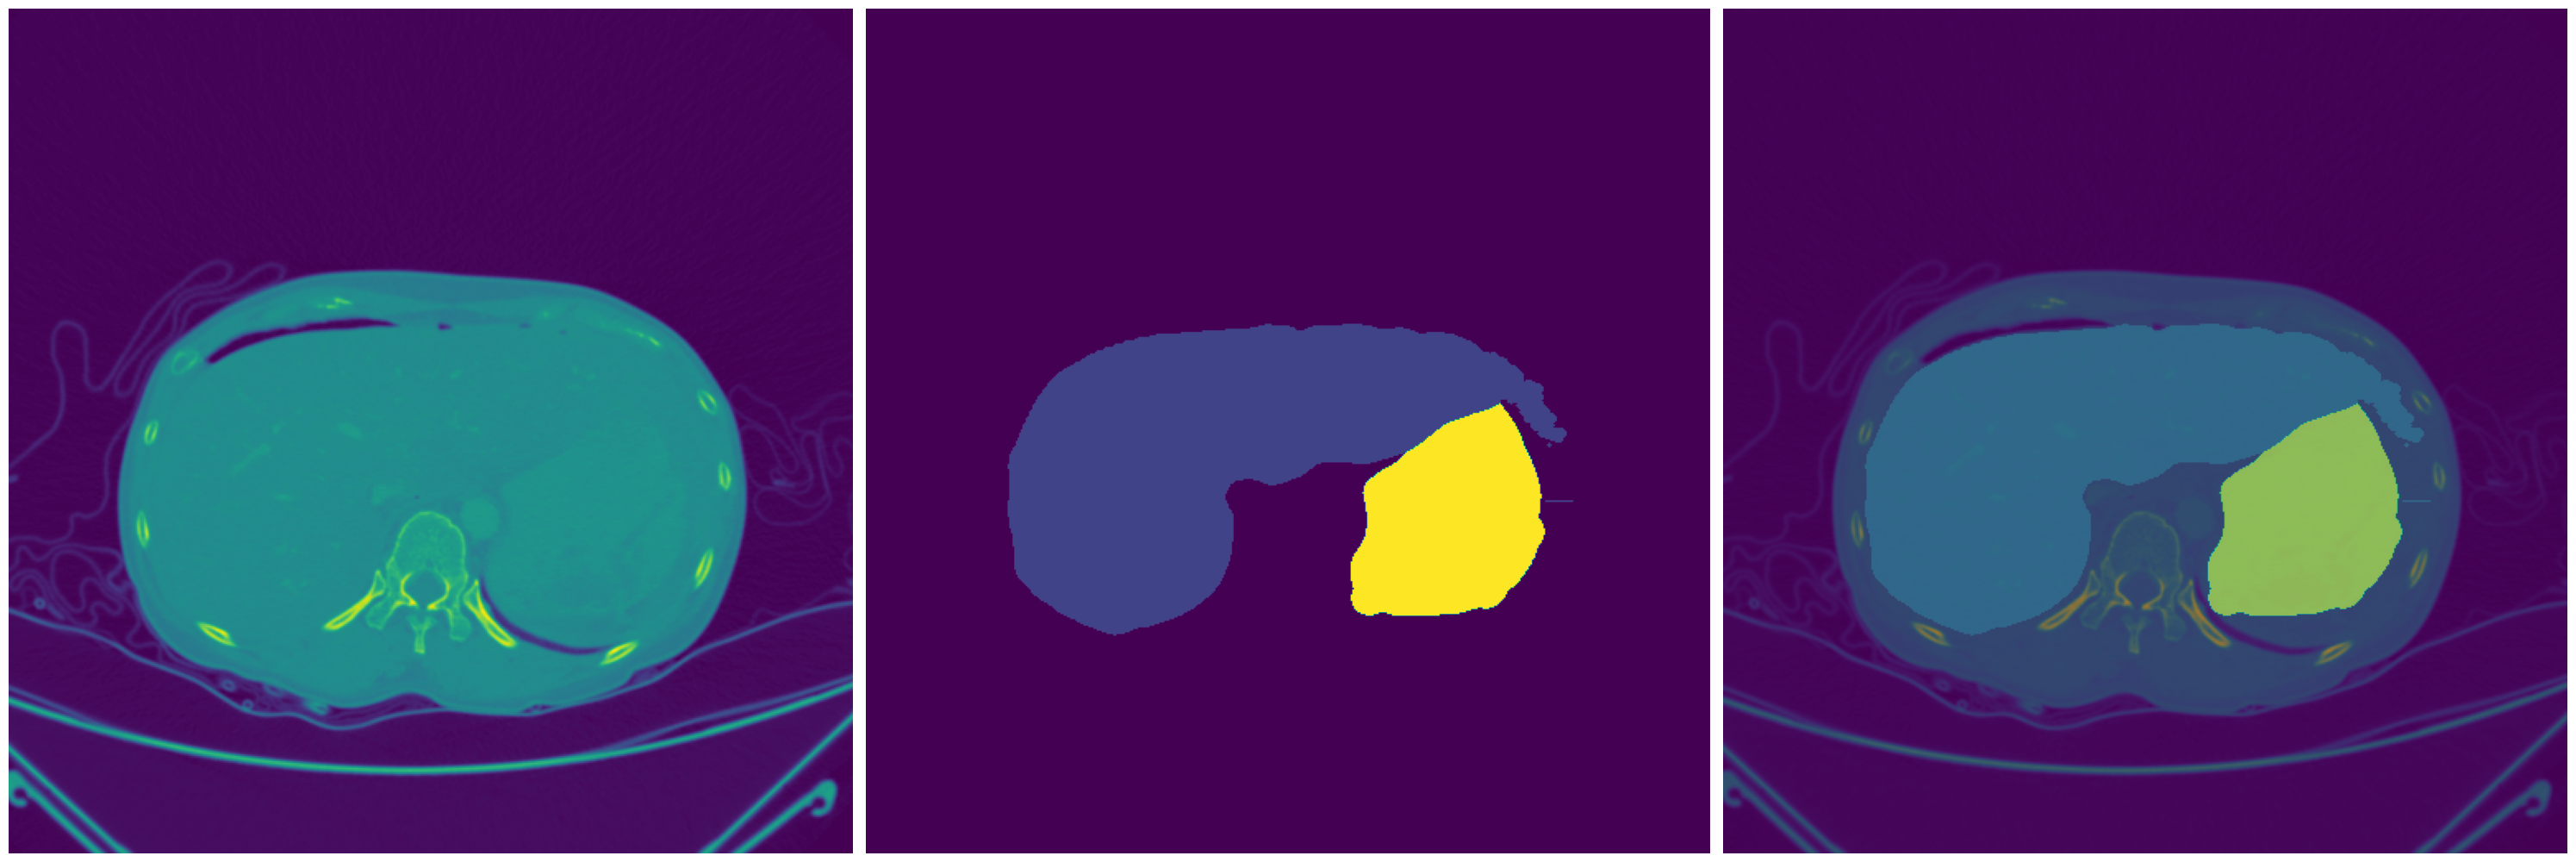

In [141]:
import matplotlib.pyplot as plt
patient_id_ex = "20951"
study_ex = "6575"
image_ex = np.load(f"data/stage2/image/{patient_id_ex}_{study_ex}_60.npy").transpose(2, 0, 1)
print(image_ex.shape)
mask_ex = np.load(f"data/stage2/mask/{patient_id_ex}_{study_ex}_60.npy").transpose(2, 0, 1)
print(mask_ex.shape)
plt.figure(figsize=(30, 20))
plt.subplot(1, 3, 1); plt.imshow(image_ex[1]); plt.axis('OFF');
plt.subplot(1, 3, 2); plt.imshow(mask_ex[1]); plt.axis('OFF');
plt.subplot(1, 3, 3); plt.imshow(image_ex[1]); plt.imshow(mask_ex[1], alpha=0.5); plt.axis('OFF');
plt.tight_layout()
plt.show()

In [6]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations

from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    if data == 'train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            CoarseDropout(max_holes=8, max_height=CFG.img_size//20, max_width=CFG.img_size//20,
                            min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'light_train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            # VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                # OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            # CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
            #              min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ])


class Stage1Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = get_transforms(data=transform)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        image_path = row.image_path
        mask_path = row.mask_path
        image = np.load(image_path)
        mask = np.load(mask_path)
        # transform
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        image = image / 255.0
        real_mask = np.zeros([5, CFG.img_size, CFG.img_size])
        for idx in range(5):
            mask_bool = (mask[:, :, 1] == (idx + 1))
            real_mask[idx] = mask_bool
        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))
        return torch.from_numpy(image), torch.from_numpy(real_mask), torch.from_numpy(mask)

In [143]:
dataset_show = Stage1Dataset(train_df, transform='train')
print(len(dataset_show))
image, mask, ori_mask = dataset_show[10]
print(image.size())
print(mask.size())

70129
torch.Size([3, 320, 320])
torch.Size([5, 320, 320])


In [7]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.out_dim,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

In [145]:
from warmup_scheduler import GradualWarmupScheduler
class GradualWarmupSchedulerV3(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV3, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch >= self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]


In [146]:
def train_one_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = torch.cuda.amp.GradScaler()
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    model.train()
    start = end = time.time()
    for step, (images, masks, raw_mask) in enumerate(train_loader):
        images = images.to(CFG.device, dtype=torch.float)
        masks = masks.to(CFG.device, dtype=torch.float)
        bs = images.size(0)
        with autocast(enabled=True):
            y_preds = model(images)
            loss = criterion(y_preds, masks)
        losses.update(loss.item(), bs)
        if CFG.accum_iter > 1:
            loss = loss / CFG.accum_iter
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.accum_iter == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(f"Epoch: [{epoch}][{step} / {len(train_loader)}]: Elapsed {timeSince(start, float(step + 1) / len(train_loader))} Loss: {(losses.val):.4f}({(losses.avg):.4f}) LR: {optimizer.param_groups[0]['lr']}")
    return losses.avg, optimizer.param_groups[0]["lr"]


def valid_one_epoch(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    model.eval()
    start = end = time.time()
    val_scores = []
    
    for step, (images, masks, raw_mask) in enumerate(valid_loader):
        data_time.update(time.time() - end)
        images = images.to(CFG.device, dtype=torch.float)
        masks = masks.to(CFG.device, dtype=torch.float)
        bs = images.size(0)
        with torch.no_grad():
            y_pred = model(images)
        loss = criterion(y_pred, masks)
        losses.update(loss.item(), bs)
        y_pred = y_pred.sigmoid()
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice])
        if CFG.accum_iter > 1:
            loss = loss / CFG.accum_iter
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(f"EVAL: [{step}/{len(valid_loader)}] Elapsed {timeSince(start, float(step + 1)/len(valid_loader))} Loss: {(losses.val):.4f} ({(losses.avg):.4f})")
    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    return losses.avg, val_scores
        

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [147]:
# training
log_dir = './logs'
model_dir = './weights'
DEBUG = False
device = CFG.device

def run(fold):
    log_file = os.path.join(log_dir, f'{CFG.backbone}_fold{fold}.txt')
    model_file = os.path.join(model_dir, f'{CFG.backbone}_fold{fold}_best.pth')
    df_seg = pd.read_csv('data/stage2/seg_25d.csv')
    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = Stage1Dataset(train_, transform='train')
    dataset_valid = Stage1Dataset(valid_, transform='valid')
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
    model = build_model()
    model = model.to(CFG.device)
    if CFG.optimizer == "AdamW":
        if CFG.scheduler_warmup in ["GradualWarmupSchedulerV2","GradualWarmupSchedulerV3"]:
            optimizer = AdamW(model.parameters(), lr=CFG.lr/CFG.warmup_factor, weight_decay=CFG.weight_decay) 
        else:
            optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)  
    # scheduler
    if CFG.scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)

    if CFG.scheduler_warmup=="GradualWarmupSchedulerV3":
        scheduler_warmup = GradualWarmupSchedulerV3(optimizer, multiplier=10, total_epoch=CFG.warmup_epo, after_scheduler=scheduler)

    DiceLoss = smp.losses.DiceLoss(mode='multilabel')
    BCELoss = smp.losses.SoftBCEWithLogitsLoss()
    # loss
    def criterion(y_pred, y_true):
        return 0.5*BCELoss(y_pred, y_true) + 0.5*DiceLoss(y_pred, y_true)
    
    # ========
    metric_best = 0.
    print(len(dataset_train), len(dataset_valid))
    print("load model successful!")
    for epoch in range(1, CFG.epochs + 1):
        start_time = time.time()
        avg_loss, cur_lr = train_one_epoch(loader_train, model, criterion, optimizer, epoch, scheduler, device)
        valid_loss, valid_scores = valid_one_epoch(loader_valid, model, criterion, device)
        valid_scores = valid_scores[0]
        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {cur_lr}, train loss: {avg_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {valid_scores:.5f}'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')
        if valid_scores > metric_best:
            print(f'metric_best {metric_best:.6f} --> {valid_scores:.6f}. Saving model...')
            torch.save(model.state_dict(), model_file)
            metric_best = valid_scores
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scaler_state_dict': scaler.state_dict() if scaler else None,
                'score_best': metric_best,
            },
            model_file.replace('_best', '_last')
        )
    del model
    torch.cuda.empty_cache()
    gc.collect()

run(0)

56071 14058
load model successful!
Epoch: [1][0 / 3505]: Elapsed 0m 2s (remain 169m 8s) Loss: 0.6298(0.6298) LR: 0.0005
Epoch: [1][100 / 3505]: Elapsed 1m 3s (remain 35m 28s) Loss: 0.4405(0.5789) LR: 0.0005
Epoch: [1][200 / 3505]: Elapsed 2m 5s (remain 34m 30s) Loss: 0.3128(0.4739) LR: 0.0005
Epoch: [1][300 / 3505]: Elapsed 3m 7s (remain 33m 15s) Loss: 0.3003(0.4133) LR: 0.0005
Epoch: [1][400 / 3505]: Elapsed 4m 9s (remain 32m 14s) Loss: 0.2136(0.3727) LR: 0.0005
Epoch: [1][500 / 3505]: Elapsed 5m 14s (remain 31m 27s) Loss: 0.2227(0.3442) LR: 0.0005
Epoch: [1][600 / 3505]: Elapsed 6m 16s (remain 30m 21s) Loss: 0.1646(0.3186) LR: 0.0005
Epoch: [1][700 / 3505]: Elapsed 7m 22s (remain 29m 28s) Loss: 0.1342(0.2953) LR: 0.0005
Epoch: [1][800 / 3505]: Elapsed 8m 23s (remain 28m 19s) Loss: 0.1639(0.2766) LR: 0.0005
Epoch: [1][900 / 3505]: Elapsed 9m 26s (remain 27m 16s) Loss: 0.1610(0.2621) LR: 0.0005
Epoch: [1][1000 / 3505]: Elapsed 10m 29s (remain 26m 15s) Loss: 0.1415(0.2498) LR: 0.0005
Ep

In [160]:
df = pd.read_csv('data/train_series_meta.csv')
aohu_info = pd.read_csv('data/aortic_info.csv')
aohu_info = aohu_info.rename(columns={'patient_id': 'cnt'})
df = df.merge(aohu_info, on='aortic_hu', how='left')
df = df[df['cnt'] >= 5]
print(len(df))
print(df.head())

4060
   patient_id  series_id  aortic_hu  incomplete_organ  cnt    weight
0       10004      21057      146.0                 0   33  4.882802
2       10005      18667      187.0                 0   19  4.330733
3       10007      47578      329.0                 0    9  3.583519
4       10026      29700      327.0                 0   12  3.871201
5       10026      42932      122.0                 0   23  4.521789


In [182]:
train_slice_list = []
for idx in tqdm(range(len(df))):
    row = df.iloc[idx]
    study_id = str(int(row.series_id))
    patient_id = str(int(row.patient_id))
    train_image_path = glob(f"data/train_images/{patient_id}/{study_id}/*")
    train_image_path = sorted(train_image_path, key=lambda x:int(x.split("/")[-1].replace(".dcm", "")))
    part_size = len(train_image_path) // 4
    # train_image_path = train_image_path[part_size: 3 * part_size]
    for path_idx in range(part_size, len(train_image_path) - 1):
        path1 = train_image_path[path_idx - 1]
        path2 = train_image_path[path_idx]
        path3 = train_image_path[path_idx + 1]
        slice_num = int(path2.split("/")[-1].replace(".dcm", ""))
        train_slice_list.append([patient_id, study_id, slice_num, path1, path2, path3])
test_df = pd.DataFrame(train_slice_list, columns=["patient_id", "study_id", "slice_num", "path1", "path2", "path3"])
test_df = test_df.sort_values(["study_id", "slice_num"], ascending=[True, True]).reset_index(drop=True)
test_df.to_csv('data/stage2/train_slice_list.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4060/4060 [02:17<00:00, 29.54it/s]


In [27]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = pydicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im2 = load_dicom(row.path2)
        im2h = im2.shape[0]
        im2w = im2.shape[1]

        im1 = load_dicom(row.path1) if row.path1 != 'nofile' else np.zeros((im2h, im2w))
        im3 = load_dicom(row.path3) if row.path3 != 'nofile' else np.zeros((im2h, im2w))

        if im1.shape != (im2h, im2w):
            im1 = cv2.resize(im1, (im2w, im2h))
        if im3.shape != (im2h, im2w):
            im3 = cv2.resize(im3, (im2w, im2h))
        image_list = [im1, im2, im3]
        image = np.stack(image_list, axis=2)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float16)
        return torch.from_numpy(image), row.study_id, row.slice_num

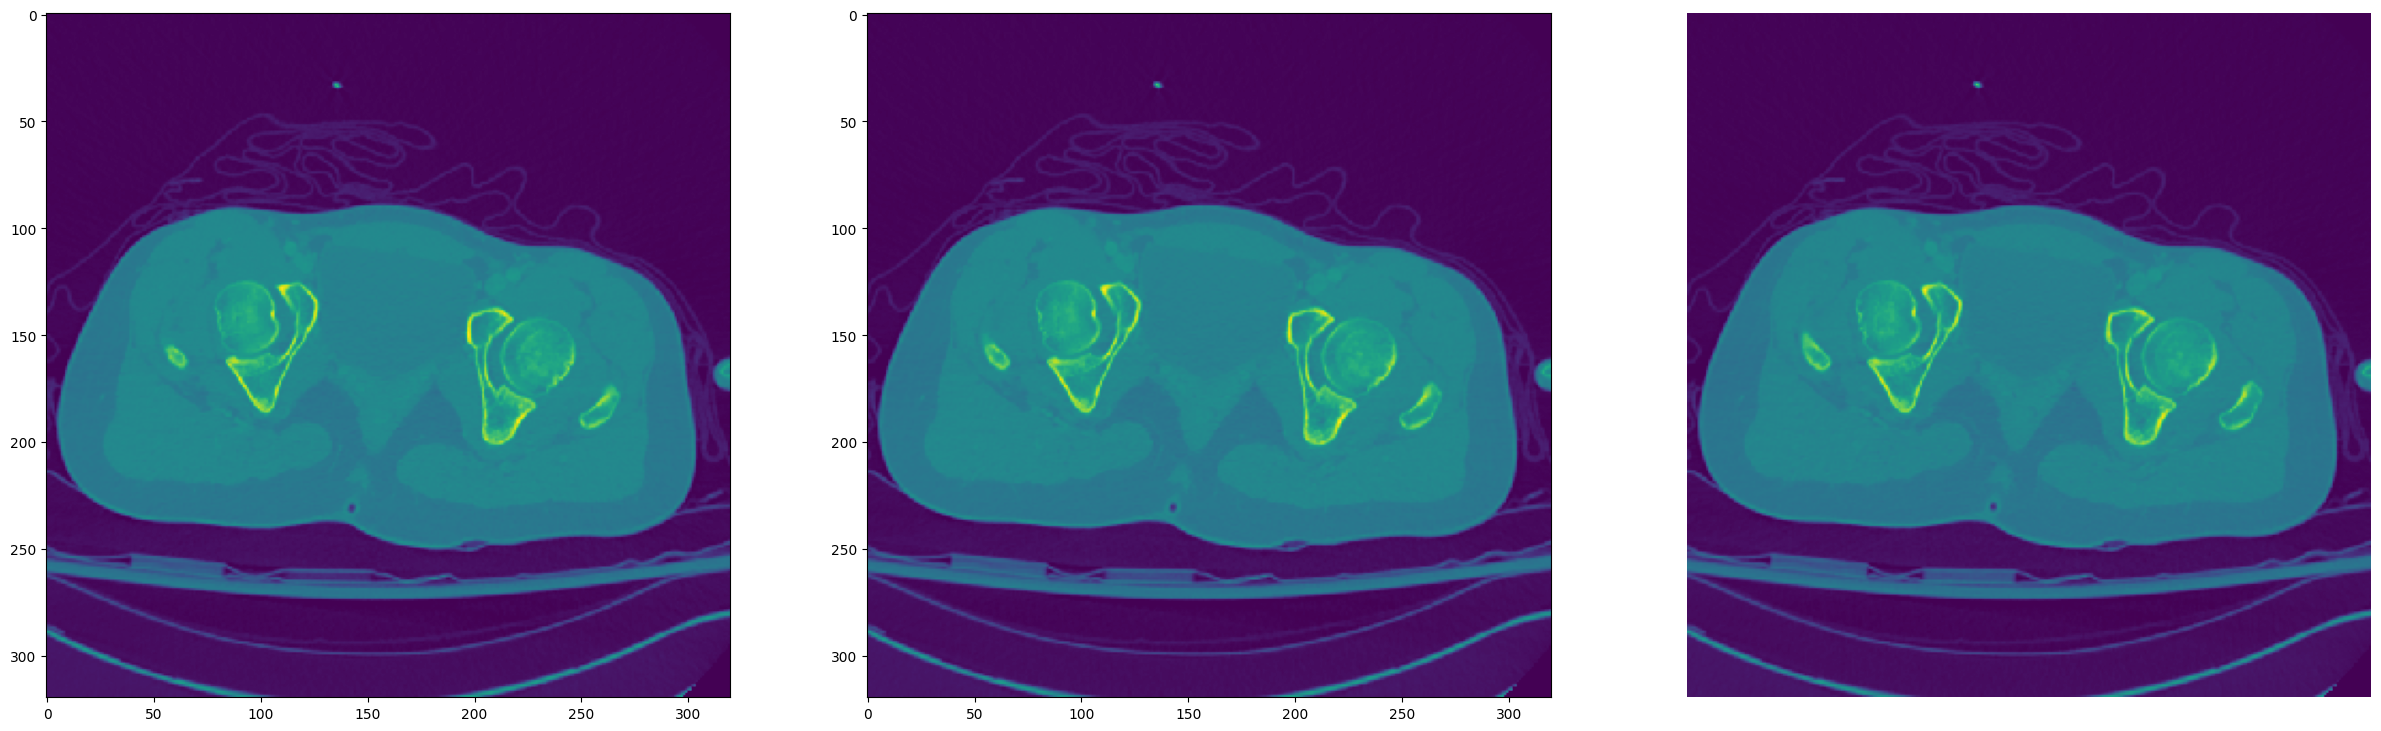

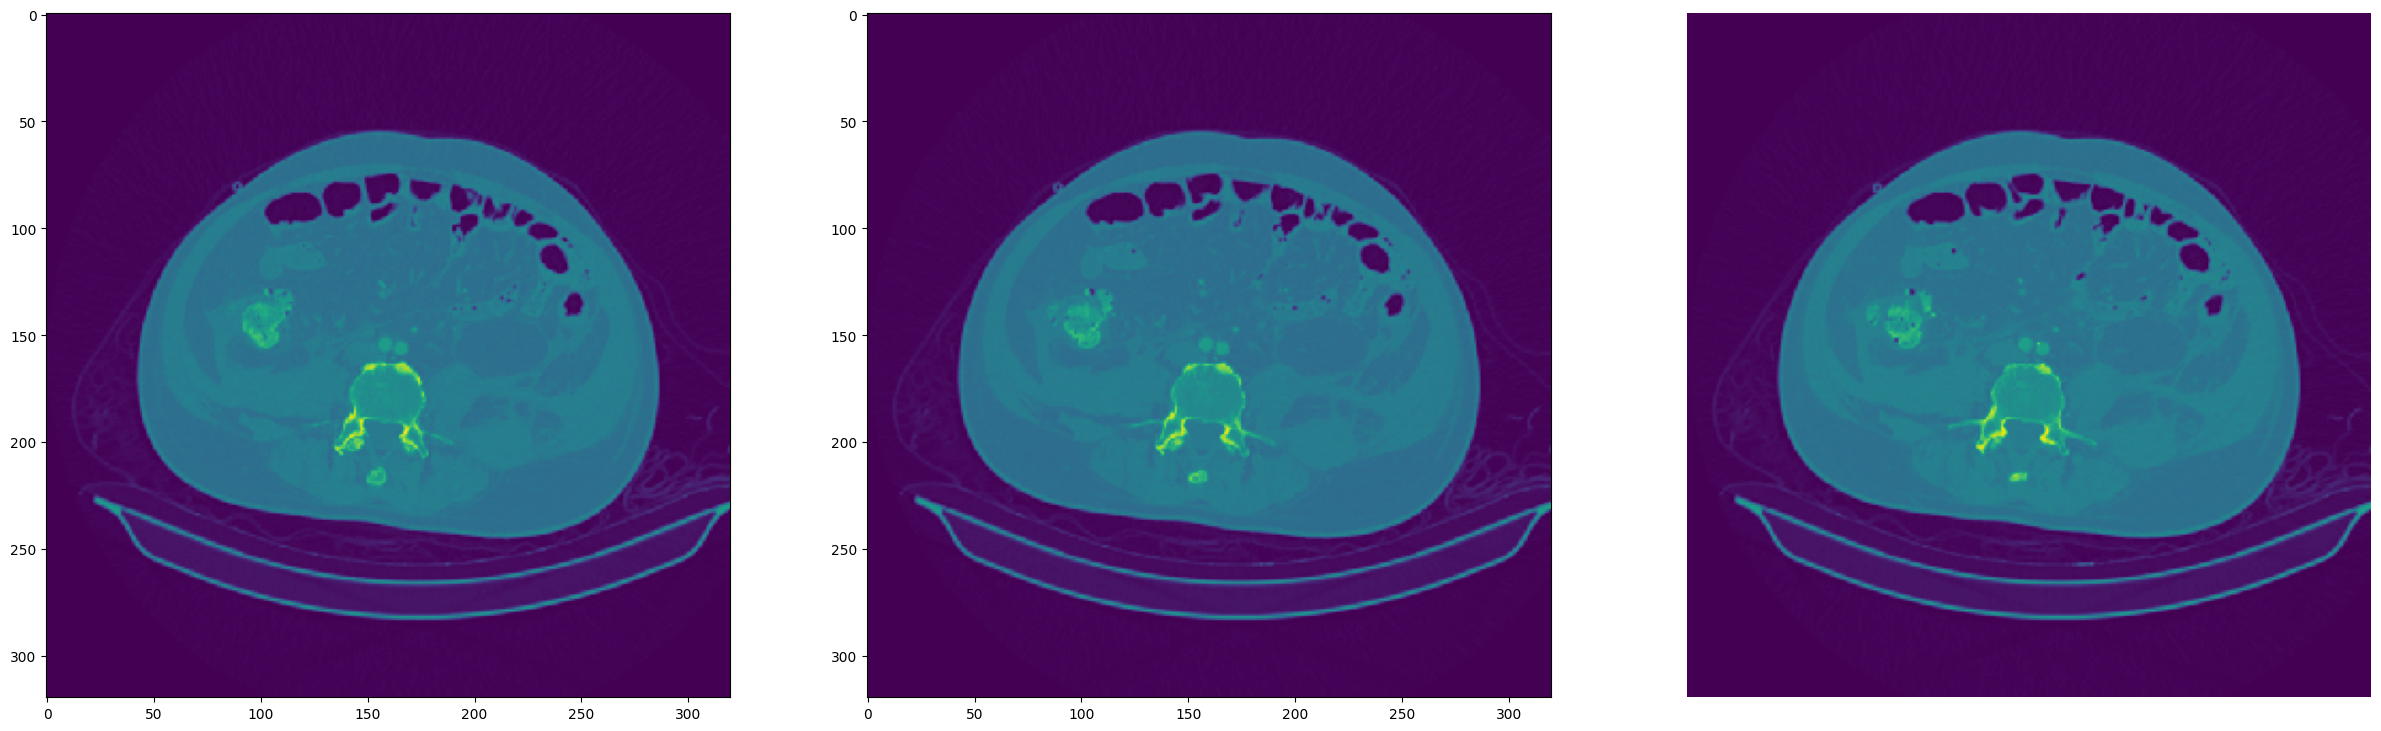

In [9]:
from pylab import rcParams
import matplotlib.pyplot as plt
test_df = pd.read_csv('data/stage2/train_slice_list.csv')
dataset_show = TestDataset(test_df, get_transforms('valid'))
rcParams['figure.figsize'] = 30, 20
for i in range(2):
    f, axarr = plt.subplots(1, 3)
    idx = np.random.randint(0, len(dataset_show))
    img, file_name, n_slice = dataset_show[idx]
    axarr[0].imshow(img[0]); plt.axis('OFF');
    axarr[1].imshow(img[1]); plt.axis('OFF');
    axarr[2].imshow(img[2]); plt.axis('OFF');

In [10]:
def crop_voxel(voxel_mask, last_f_name):
    area_thr = 10
    # x
    x_list = []
    length = voxel_mask.shape[0]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
            x_list.append(i)
            break
    else:
        x_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
            x_list.append(i)
            break
    else:
        x_list.append(length-1)

    # y
    y_list = []
    length = voxel_mask.shape[1]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[:, i]).item() >= area_thr:
            y_list.append(i)
            break
    else:
        y_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[:, i]).item() >= area_thr:
            y_list.append(i)
            break
    else:
        y_list.append(length-1)

    # z
    z_list = []
    length = voxel_mask.shape[2]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[:, :, i]).item() >= area_thr:
            z_list.append(i)
            break
    else:
        z_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[:, :, i]).item() >= area_thr:
            z_list.append(i)
            break
    else:
        z_list.append(length-1)
    
    try:
        croped_voxel_mask = voxel_mask[x_list[0]:x_list[1]+1, y_list[0]:y_list[1]+1, z_list[0]:z_list[1]+1]
    except:
        print(f"last_f_name:{last_f_name}, voxel_mask.shape:{voxel_mask.shape}, x_list:{x_list}, y_list:{y_list}, z_list:{z_list}")
        x_list = [0, voxel_mask.shape[0]-1]; y_list = [0, voxel_mask.shape[1]-1]; z_list = [0, voxel_mask.shape[2]-1]
        croped_voxel_mask = voxel_mask
    voxel_crop_list.append([last_f_name, voxel_mask.shape[1], x_list[0], x_list[1] + 1, y_list[0], y_list[1] + 1, z_list[0], z_list[1] + 1])
    croped_voxel_mask = croped_voxel_mask.to('cpu').numpy().astype(np.uint8)
    for x_idx in range(croped_voxel_mask.shape[0]):
        slice_mask = croped_voxel_mask[x_idx]

        unique, counts = np.unique(slice_mask, return_counts=True)
        if len(unique) == 1 and unique[0] == 0:
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0], 0])
        elif unique[0] == 0:
            unique = unique[1:]
            counts = counts[1:]
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0]+1, unique[counts.argmax()]])
        else:
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0]+1, unique[counts.argmax()]])
        
    return None, croped_voxel_mask 

In [28]:
CFG.batch_size = 128
test_dataset = TestDataset(test_df, transform=get_transforms("valid"))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)
model = load_model('weights/efficientnet-b0_fold0_best.pth')
model.eval()
print(f'load model successfull! with {len(test_dataset)} sample')


load model successfull! with 967542 sample


In [29]:
last_f_name = ""
voxel_mask = []
slice_class_list = []
voxel_crop_list = []
for step, (images, study_id, n_slice) in tqdm(enumerate(test_loader), total=len(test_loader)):
    try:
        images = images.to(CFG.device, dtype=torch.float)
        bs = images.size(0)
        with torch.no_grad():
            y_pred = model(images)
        y_pred = y_pred.sigmoid()
        slice_mask_max = torch.max(y_pred, 1)
        slice_mask = torch.where((slice_mask_max.values) > 0.5, slice_mask_max.indices + 1, 0)
        start_idx = 0
        for bs_idx in range(CFG.batch_size):
            f_name = study_id[bs_idx]
            if f_name != last_f_name:
                voxel_mask.append(slice_mask[start_idx: bs_idx])
                voxel_mask = torch.cat(voxel_mask, dim=0)
                if len(voxel_mask) > 0:
                    croped_voxel, croped_voxel_mask = crop_voxel(voxel_mask, last_f_name)
                last_f_name = f_name
                start_idx = bs_idx
                voxel_mask = [] 
            elif bs_idx == CFG.batch_size - 1:
                voxel_mask.append(slice_mask[start_idx:CFG.batch_size])
    except:
        print('debug', study_id)
        continue
    
voxel_mask = torch.cat(voxel_mask, dim=0)
if len(voxel_mask) > 0:
    croped_voxel, croped_voxel_mask = crop_voxel(voxel_mask, last_f_name)

voxel_crop_df = pd.DataFrame(voxel_crop_list, columns=["study_id", "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1"])
voxel_crop_df.to_csv("data/stage2/voxel_crop.csv", index=False)
voxel_crop_df.head()

slice_class_df = pd.DataFrame(slice_class_list, columns=["study_id", "new_slice_num", "old_slice_num", "cnt"])
slice_class_df.to_csv("data/stage2/slice_class.csv", index=False)
slice_class_df.head()

 35%|█████████████████████████████████████████████▉                                                                                      | 2634/7559 [1:45:09<2:30:30,  1.83s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f798dc91940>
Traceback (most recent call last):
  File "/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f798dc91940>
Traceback (most recent call last):
  File "/data1/ocr_ie/anaconda3/en

debug tensor([ 999,  999,  999,  999,  999,  999,  999,  999,  999,  999,  999,  999,
         999,  999,  999,  999,  999,  999,  999,  999,  999,  999,  999,  999,
         999,  999,  999,  999,  999,  999,  999,  999,  999,  999,  999,  999,
         999,  999,  999,  999,  999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
        9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
        9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
        9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
        9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
        9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999,
        9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999, 9999])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7559/7559 [5:03:08<00:00,  2.41s/it]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
# gen new_df
study_id_list = []
slice_num_list = []
voxel_crop_df = voxel_crop_df.merge(df, on='study_id', how='left')
for idx in range(len(voxel_crop_df)):
    row = voxel_crop_df.iloc[idx]
    patient_id = row.patient_id
    study_id = row.study_id
    train_image_path = glob(f"data/train_images/{patient_id}/{study_id}/*")
    train_image_path = sorted(train_image_path, key=lambda x: int(x.split("/")[-1].replace(".dcm", "")))
    slice_cnt = len(train_image_path)
    study_id_list.extend([study_id] * slice_cnt)
    slice_num_list.extend([int(x.split("/")[-1].replace(".dcm", "")) for x in train_image_path])
all_slice_df = pd.DataFrame({"study_id": study_id_list, "slice_num": slice_num_list})
all_slice_df.to_csv("data/stage2/all_slice_df.csv", index=False)

In [ ]:
new_df = []
for idx, study_id, _, x0, x1, _, _, _, _ in tqdm(voxel_crop_df.itertuples(), total=len(voxel_crop_df)):
    one_study = all_slice_df[all_slice_df["study_id"] == study_id].reset_index(drop=True)
    new_df.append(one_study[x0:x1])
new_df = pd.concat(new_df, axis=0).reset_index(drop=True)
new_df = new_df.merge(voxel_crop_df, on='study_id', how='left')

In [ ]:
new_slice_df = pd.concat([new_df, slice_class_df[['new_slice_num', 'cnt']]], axis=1)
tr_df = pd.read_csv("data/train.csv")
new_slice_df1 = new_slice_df.merge(tr_df, on="StudyInstanceUID", how="left")
new_slice_df1.to_csv("data/stage2/train_slice.csv", index=False)
print(new_slice_df1.head())

In [ ]:
sample_num = 24
organ_df_list = []
for study_id in tqdm(np.unique(new_slice_df1['study_id'])):
    one_study = new_slice_df1[new_slice_df1['study_id'] == study_id].reset_index(drop=True)
    for cid in range(1, 6):
        one_study_cid = one_study[one_study['vertebra_class'] == cid].reset_index(drop=True)
        if len(one_study_cid) >= sample_num:
            sample_index = np.linspace(0, len(one_study_cid) - 1, sample_num, dtype=int)
            one_study = one_study.iloc[sample_index].reset_index(drop=True)
        if len(one_study_cid) < 1:
            continue
        slice_num_list = one_study["slice_num"].values.tolist()
        arow = one_study.iloc[0]
        organ_df_list.append([f"{study_id}_{cid}", study_id, cid, slice_num_list, arow['before_image_size'], arow['x0'], arow['x1'], arow['y0'], arow['y1'], arow['z0'], arow['z1']])
organ_df = pd.DataFrame(organ_df_list, columns=['study_cid', 'study_id', 'cid', 'slice_num_list', 'before_image_size', 'x0', 'x1', 'y0', 'y1', 'z0', 'z1', 'label'])
organ_df.to_pickle('data/stage2/organ_df.pkl')

In [ ]:
# study level
